In [69]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# 데이터 다운로드
training_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor(),
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [70]:
# 배치 크기 결정
batch_size = 64

# 데이터 로드
train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of X [N, C, H, W]: {y.dtype}')

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of X [N, C, H, W]: torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of X [N, C, H, W]: torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of X [N, C, H, W]: torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of X [N, C, H, W]: torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of X [N, C, H, W]: torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of X [N, C, H, W]: torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of X [N, C, H, W]: torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of X [N, C, H, W]: torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of X [N, C, H, W]: torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of X [N, C, H, W]: torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of X [N, C, H, W]: torch.int64
Shape of X

In [71]:
## 훈련 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [77]:
## 모델 정의
class NeuralNetwork(nn.Module):
	def __init__(self):
		super(NeuralNetwork, self).__init__()
		self.flatten = nn.Flatten()
		self.linear_relu_stack = nn.Sequential(
			nn.Linear(28*28, 512),
			nn.ReLU(),
			nn.Linear(512, 512),
			nn.ReLU(),
			nn.Linear(512, 10)
		)

	def forward(self, x):
		x = self.flatten(x)
		logits = self.linear_relu_stack(x)
		return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [78]:
## 모델의 매계변수 최적화
### 모델 학습을 위해서는 손실함수와 옵티마이저가 필요하다
# loss_fn = nn.CrossEntropyLoss() ## 손실 함수
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1) ## 최적화 함수, lr = 학습률(하이퍼 파라미터)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [79]:
## 훈련 당 학습 데이터셋의 배치 데이터로 뽑은 예측 오류를 역전파하여 모델의 매계변수를 조정
def train(dataloader, model, loss_fn, optimizer):
	size = len(dataloader.dataset)

	for batch, (X, y) in enumerate(dataloader):
		X, y = X.to(device), y.to(device)

		# 예측 오류 계산
		pred = model(X)
		loss = loss_fn(pred, y)

		# 역전파
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if batch % 100 == 0:
			loss, current = loss.item(), batch * len(X)
			print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [80]:
## 테스트 데이터 셋으로 모델의 성능 확인
def test(dataloader, model, loss_fn):
	size = len(dataloader.dataset)
	num_batches = len(dataloader)
	model.eval()
	test_loss, correct = 0, 0
	with torch.no_grad():
		for X, y in dataloader:
			X, y = X.to(device), y.to(device)
			pred = model(X)
			test_loss += loss_fn(pred, y).item()
			correct += (pred.argmax(1) == y).type(torch.float).sum().item()
	test_loss /= num_batches
	correct /= size
	print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [81]:
epochs = 5
for t in range(epochs):
	print(f"Epoch {t+1}\n-------------------------------")
	train(train_dataloader, model, loss_fn, optimizer)
	test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306822  [    0/60000]
loss: 2.300355  [ 6400/60000]
loss: 2.281661  [12800/60000]
loss: 2.272327  [19200/60000]
loss: 2.263780  [25600/60000]
loss: 2.222532  [32000/60000]
loss: 2.233161  [38400/60000]
loss: 2.190797  [44800/60000]
loss: 2.188606  [51200/60000]
loss: 2.168124  [57600/60000]
Test Error: 
 Accuracy: 36.0%, Avg loss: 2.159427 

Epoch 2
-------------------------------
loss: 2.166669  [    0/60000]
loss: 2.160526  [ 6400/60000]
loss: 2.107882  [12800/60000]
loss: 2.125796  [19200/60000]
loss: 2.078160  [25600/60000]
loss: 2.011115  [32000/60000]
loss: 2.038693  [38400/60000]
loss: 1.954635  [44800/60000]
loss: 1.960766  [51200/60000]
loss: 1.904349  [57600/60000]
Test Error: 
 Accuracy: 54.5%, Avg loss: 1.895626 

Epoch 3
-------------------------------
loss: 1.922020  [    0/60000]
loss: 1.896826  [ 6400/60000]
loss: 1.788645  [12800/60000]
loss: 1.828436  [19200/60000]
loss: 1.718920  [25600/60000]
loss: 1.666389  [32000/600

In [82]:
## 학습된 모델 저장
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [83]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [84]:
classes = [
	"T-shirt/top",
	"Trouser",
	"Pullover",
	"Dress",
	"Coat",
	"Sandal",
	"Shirt",
	"Sneaker",
	"Bag",
	"Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
	pred = model(x)
	predicted, actual = classes[pred[0].argmax(0)], classes[y]
	print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


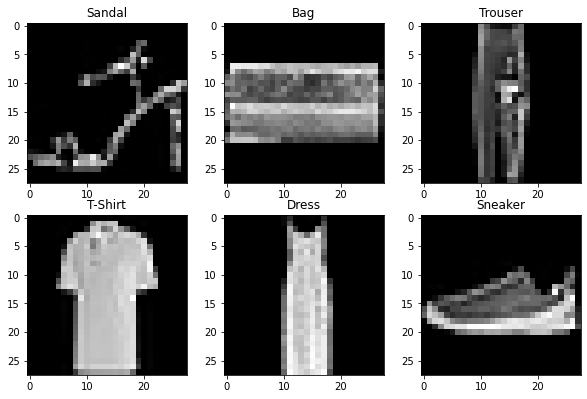

In [92]:
## 데이터 시각화하기
import matplotlib.pyplot as plt

label_map = {
	0: "T-Shirt",
	1: "Trouser",
	2: "Pullover",
	3: "Dress",
	4: "Coat",
	5: "Sandal",
	6: "Shirt",
	7: "Sneaker",
	8: "Bag",
	9: "Ankle Boot",
}

fig = plt.figure(figsize = (10, 10))
cols, rows = 3, 3
for i in range(1, cols + rows + 1):
	random_idx = torch.randint(len(training_data), size = (1,)).item() ## 범위 내의 랜덤한 인덱스값 생성
	img, label = training_data[random_idx] ## 데이터 셋에서 랜덤 데이터 가져오기
	fig.add_subplot(rows, cols, i) ## 그림의 크기 설정
	plt.title(label_map[label]) ## 타이틀
	plt.imshow(img.squeeze(), cmap = 'gray')

plt.show()

In [94]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image

In [96]:
class CustomImageDataset(Dataset):
	def __init__(self, annotation_file, img_dir, transform, target_transform = None):
		self.img_labels = pd.read_csv(annotation_file, names = ['file_name', 'label'])
		self.img_dir = img_dir
		self.transform = transform
		self.target_transform = target_transform

	def __len__(self):
		return len(self.img_labels)

	def __getitem__(self, idx):
		img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
		image =  read_image(img_path)

		label = self.img_labels.iloc[idx, 1]
		if self.transform:
			image = self.transform(image)
		if self.target_transform:
			label = self.target_transform(label)
		return image, label

In [97]:
# 데이터 셋 학습
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle =  True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


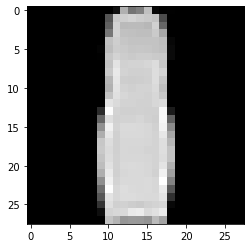

Label: 3


In [109]:
# 데이터 학습

train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Label batch shape: {train_labels.size()}')
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap = 'gray')
plt.show()
print(f'Label: {label}')